In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
from hit_finding.constants import *
from hit_finding.metrics import *

## Compare between plates

In [8]:
zscores = extract_scores_from_all(extract_score, threshold=5)

...................................

In [9]:
joined = pd.concat(zscores.values())

In [10]:
filter_hit = 0.4

In [11]:
joined.query(f'ALL_map > {filter_hit}').index.get_level_values(1).duplicated(False).sum()

41

In [12]:
joined = pd.concat(zscores.values())
dup_compunds = joined[joined.index.get_level_values(1).duplicated(False)]

# dup_compunds = dup_compunds[dup_compunds.groupby('Metadata_broad_sample').count() > 2]

In [13]:
joined.shape, dup_compunds.shape

((11197, 18), (2877, 18))

Singles 8320
Couples 960
Triplets 319


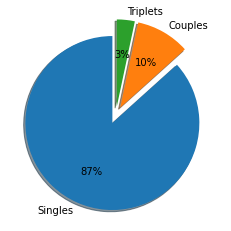

In [16]:
count_compounds = joined['ALL_map'].groupby('Metadata_broad_sample').count()
counters = [(count_compounds == i).sum() for i in [0, 1, 2, 3]]

print('Singles', counters[1])
print('Couples', counters[2])
print('Triplets', counters[3])

plt.pie(counters[1:], labels = ['Singles', 'Couples', 'Triplets'], autopct='%1.f%%',
        shadow=True, startangle=90, explode=(0.1,0.1,0.1))
plt.show()

Singles 85
Couples 10
Triplets 7


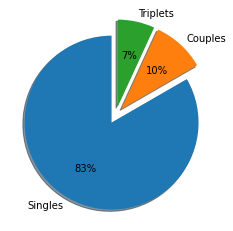

In [17]:
count_compounds = joined.query(f'ALL_map > {filter_hit}')['ALL_map'].groupby('Metadata_broad_sample').count()

names = [list(count_compounds[count_compounds == i].index) for i in [0, 1, 2, 3]]
counters = [len(n) for n in names]

print('Singles', counters[1])
print('Couples', counters[2])
print('Triplets', counters[3])

plt.pie(counters[1:], labels = ['Singles', 'Couples', 'Triplets'], autopct='%1.f%%',
        shadow=True, startangle=90, explode=(0.1,0.1,0.1))
plt.show()

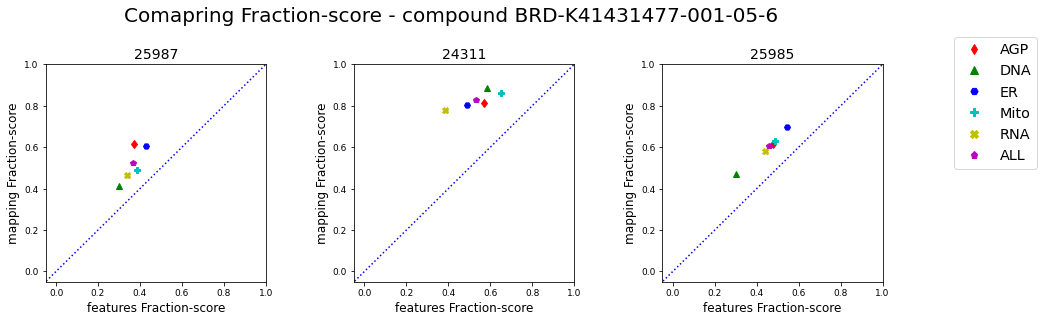

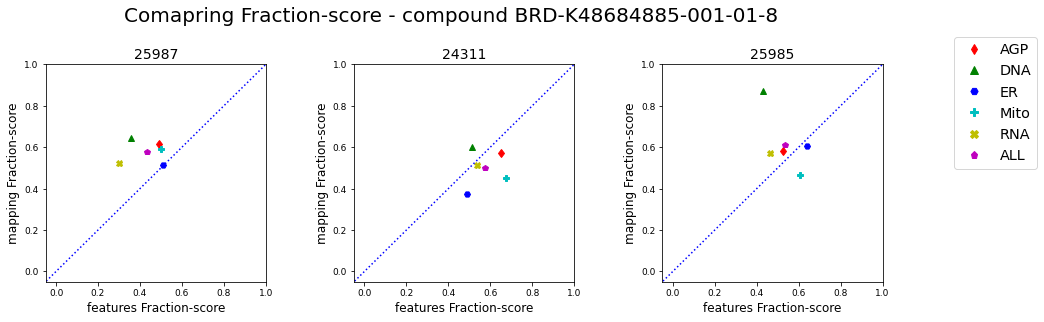

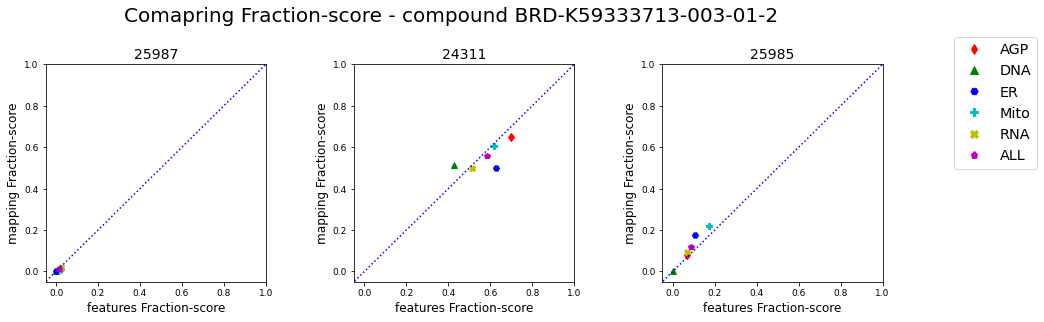

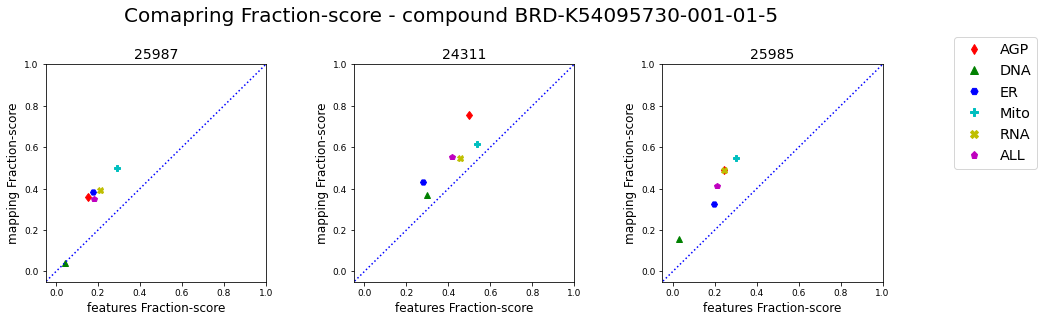

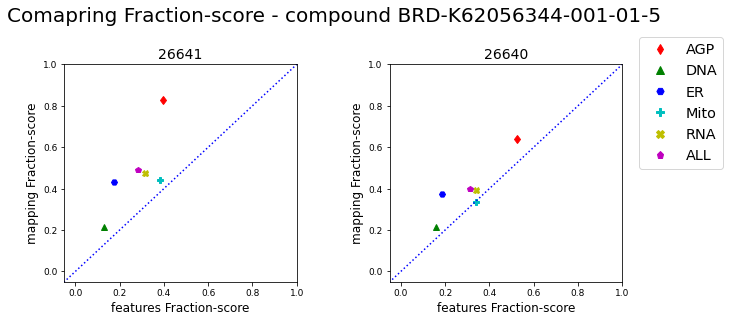

In [18]:
# compare_path = f'{plots_path}/compare'
# makedirs(compare_path, exist_ok=True)



markers = ['d', '^', 'H', 'P', 'X','p']
colors = ['r', 'g', 'b', 'c', 'y', 'm']
d={'xlabel':"features Fraction-score", 'ylabel':"mapping Fraction-score"}

# for compound in dup_compunds.query(f'ALL_map > {filter_map}').index.get_level_values(1).unique():
for compound in dup_compunds.query(f'ALL_map > {filter_hit}').sample(5).index.get_level_values(1).unique():
    curr_df = dup_compunds[dup_compunds.index.get_level_values(1) == compound]
    
    ncols = curr_df.shape[0]
    fig, ax = plt.subplots(ncols=ncols, figsize=(ncols*5, 4), sharey=True, sharex=True, subplot_kw=d, facecolor='white')
    fig.subplots_adjust(hspace=1, wspace=0.4)
    fig.suptitle(f'Comapring Fraction-score - compound {compound}', fontsize = 20, y=1.08)
    
    symbols = [0,0,0,0,0,0]
    for i, (index, row) in enumerate(curr_df.iterrows()):
        for j, chan in enumerate(CHANNELS):
            symbols[j] = ax[i].plot(row[chan+"_raw"], row[chan+"_map"], f'{colors[j]}{markers[j]}')[0]
            
        symbols[-1] = ax[i].plot(row['ALL_raw'], row["ALL_map"], f'{colors[-1]}{markers[-1]}')[0]


        ax[i].plot(range(-10, 150),range(-10, 150), 'b:')
#         ax[i].set(xlim=(0, 50), ylim=(0, 50))
        ax[i].set(xlim=(-0.05, 1), ylim=(-0.05, 1))
#         ax[i].set_yscale('symlog')
#         ax[i].set_xscale('symlog')
        ax[i].set_title(f'{index[0]}')
        ax[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=False, left=True, right=False)
        ax[i].tick_params(axis='both', labelsize = 9)
        ax[i].yaxis.label.set_size(12)
        ax[i].xaxis.label.set_size(12)
        ax[i].title.set_size(14)
    

    fig.legend(symbols, CHANNELS+["ALL"], markerscale=1.2, fontsize='x-large', bbox_to_anchor=(1.05,1))
#     fig.savefig(f'{compare_path}/{compound}.eps', format='eps')

plt.show()

In [19]:
compound = ['BRD-K52313696-001-01-6']
# compound = dup_compunds.query(f'ALL_map > {filter_map}').sample(1).index.get_level_values(1).unique()
curr_df = dup_compunds[dup_compunds.index.isin(compound, 1)]
curr_df

,,,AGP_map,DNA_map,ER_map,Mito_map,RNA_map,ALL_map,AGP_raw,DNA_raw,ER_raw,Mito_raw,RNA_raw,ALL_raw,AGP_raw1to1,DNA_raw1to1,ER_raw1to1,Mito_raw1to1,RNA_raw1to1,ALL_raw1to1
Plate,Metadata_broad_sample,Image_Metadata_Well,,,,,,,,,,,,,,,,,,
25987,BRD-K52313696-001-01-6,j11,0.546512,0.228571,0.360465,0.500000,0.534884,0.442029,0.255814,0.128571,0.162791,0.337209,0.325581,0.246377,0.232558,0.128571,0.127907,0.279070,0.255814,0.207729
24311,BRD-K52313696-001-01-6,j11,0.674419,0.300000,0.558140,0.581395,0.569767,0.545894,0.511628,0.200000,0.476744,0.593023,0.476744,0.461353,0.430233,0.142857,0.348837,0.511628,0.406977,0.376812
25985,BRD-K52313696-001-01-6,j11,0.569767,0.228571,0.406977,0.534884,0.523256,0.461353,0.290698,0.057143,0.244186,0.267442,0.302326,0.239130,0.279070,0.057143,0.197674,0.255814,0.255814,0.214976


In [21]:
curr_df = joined.query(f'ALL_map > {filter_hit}').sample(3)
curr_df

AGP_map   DNA_map  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24321 BRD-K63606607-001-01-8 d17                  0.627907  0.485714   
25422 BRD-K35396724-001-06-8 c07                  0.500000  0.328571   
      BRD-K02615925-003-06-3 i22                  0.500000  0.842857   

                                                    ER_map  Mito_map  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24321 BRD-K63606607-001-01-8 d17                  0.488372  0.500000   
25422 BRD-K35396724-001-06-8 c07                  0.511628  0.534884   
      BRD-K02615925-003-06-3 i22                  0.627907  0.813953   

                                                   RNA_map   ALL_map  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24321 BRD-K63606607-001-01-8 d17                  0.441860  0.509662   
25422 BRD-K35396724-001-06-8 c07                  0.523256  0.485507   
      BRD-K02615925-003-06-3 i22                  0.709302  0.693237   

                                                   AGP_raw   DNA_raw  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24321 BRD-K63606607-001-01-8 d17                  0.523256  0.471429   
25422 BRD-K35396724-001-06-8 c07                  0.279070  0.157143   
      BRD-K02615925-003-06-3 i22                  0.267442  0.914286   

                                                    ER_raw  Mito_raw  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24321 BRD-K63606607-001-01-8 d17                  0.558140  0.558140   
25422 BRD-K35396724-001-06-8 c07                  0.395349  0.290698   
      BRD-K02615925-003-06-3 i22                  0.465116  0.430233   

                                                   RNA_raw   ALL_raw  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24321 BRD-K63606607-001-01-8 d17                  0.383721  0.500000   
25422 BRD-K35396724-001-06-8 c07                  0.255814  0.280193   
      BRD-K02615925-003-06-3 i22                  0.488372  0.497585   

                                                  AGP_raw1to1  DNA_raw1to1  \
Plate Metadata_broad_sample  Image_Metadata_Well                             
24321 BRD-K63606607-001-01-8 d17                     0.430233     0.328571   
25422 BRD-K35396724-001-06-8 c07                     0.267442     0.142857   
      BRD-K02615925-003-06-3 i22                     0.186047     0.685714   

                                                  ER_raw1to1  Mito_raw1to1  \
Plate Metadata_broad_sample  Image_Metadata_Well                             
24321 BRD-K63606607-001-01-8 d17                    0.395349      0.476744   
25422 BRD-K35396724-001-06-8 c07                    0.348837      0.267442   
      BRD-K02615925-003-06-3 i22                    0.372093      0.174419   

                                                  RNA_raw1to1  ALL_raw1to1  
Plate Metadata_broad_sample  Image_Metadata_Well                            
24321 BRD-K63606607-001-01-8 d17                     0.302326     0.388889  
25422 BRD-K35396724-001-06-8 c07                     0.232558     0.256039  
      BRD-K02615925-003-06-3 i22                     0.441860     0.359903

In [22]:
cols = CHANNELS + ['ALL']

def calculate_center(row):
    map_vals = [row[f'{col}_map'] for col in cols]
    raw_vals = [row[f'{col}_raw'] for col in cols]
    
    return np.mean(raw_vals), np.mean(map_vals)

def calculate_euclidian_distance(pnt1, pnt2):
    x1, y1 = pnt1
    x2, y2 = pnt2
    
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2, 2))

from itertools import combinations
def compare_compounds_pairs(df, verbose=0):
    compares = []
    for (idx1,row1),(idx2,row2) in combinations(df.iterrows(), 2):
        if verbose:
            print(f'Between plates {idx1[0]} and {idx2[0]}')

        center1 = calculate_center(row1)
        center2 = calculate_center(row2)
        if verbose:
            print(f'Center of row1: {center1[0]:.2f},{center1[1]:.2f}')
            print(f'Center of row2: {center2[0]:.2f},{center2[1]:.2f}')

        center_dist = calculate_euclidian_distance(center1, center2)
        if verbose:
            print(f'Centers distance: {center_dist:.4f}')

        center_dlt = center1[0]-center2[0], center1[1]-center2[1]
        if verbose:
            print(f'Centers delta: {center_dlt[0]:.4f},{center_dlt[1]:.4f}')


        sum_dist = sum(calculate_euclidian_distance(
            (row1[f'{col}_raw'], row1[f'{col}_map']),
            (row2[f'{col}_raw'] + center_dlt[0], row2[f'{col}_map'] + center_dlt[1]))
            for col in cols)

        normalized_dist = sum_dist/len(cols)

        if verbose:
            print(f'Summation Distance of points: {sum_dist:.4f}')
            print(f'Normalized Distance of points: {normalized_dist:.4f}')
            print()
            
        compares.append({
            'Center 1 - X' : center1[0],
            'Center 1 - Y' : center1[1],
            'Center 2 - X' : center2[0],
            'Center 2 - Y' : center2[1],
            'Center Distance' : center_dist,
            'Center Delta X': center_dlt[0],
            'Center Delta Y': center_dlt[1],
            'Summation Distance Pairwise': sum_dist,
            'Normalized Distance Pairwise': normalized_dist
        })
    
    return compares

In [25]:
compares = []
for compound in names[2]+names[3]:
    compares.extend(compare_compounds_pairs(joined[joined.index.get_level_values(1) == compound]))

compares_dup = {k: [dic[k] for dic in compares] for k in compares[0]}

In [26]:
len(compares_dup['Summation Distance Pairwise'])

37

In [27]:
compares = pd.concat(joined[joined.index.get_level_values(1) == compound].iloc[:1] for compound in names[1])
compares = compare_compounds_pairs(compares)

compares_sing = {k: [dic[k] for dic in compares] for k in compares[0]}

In [28]:
len(compares_sing['Summation Distance Pairwise'])

3570

In [29]:
compares_sing['Type'] = ['Different']* len(compares_sing['Summation Distance Pairwise'])
compares_dup['Type'] = ['Same']* len(compares_dup['Summation Distance Pairwise'])

In [30]:
compares = {k: compares_sing[k] + compares_dup[k] for k in compares_sing.keys()}

In [31]:
compares = pd.DataFrame(compares).melt(id_vars='Type',var_name='Metrics')
compares

,Type,Metrics,value
0,Different,Center 1 - X,0.419661
1,Different,Center 1 - X,0.419661
2,Different,Center 1 - X,0.419661
3,Different,Center 1 - X,0.419661
4,Different,Center 1 - X,0.419661
...,...,...,...
32458,Same,Normalized Distance Pairwise,0.050377
32459,Same,Normalized Distance Pairwise,0.056743
32460,Same,Normalized Distance Pairwise,0.076056
32461,Same,Normalized Distance Pairwise,0.075770


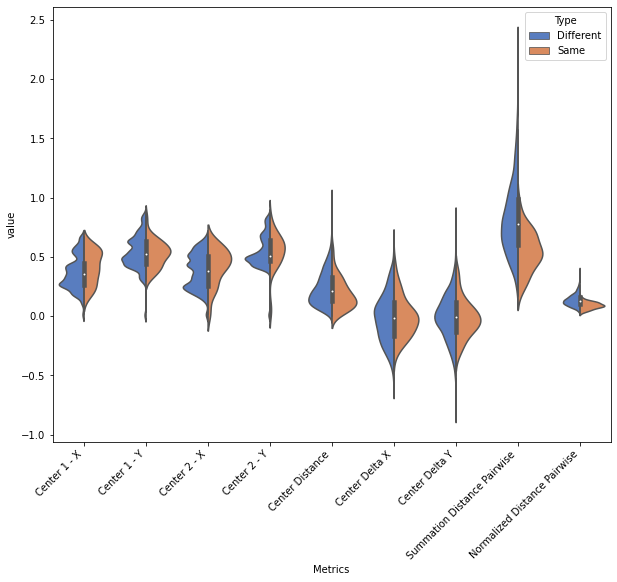

In [34]:
fig, ax = plt.subplots(figsize=(10,8), facecolor='#ffffff')
sns.violinplot(x="Metrics", y="value", hue="Type",
                    data=compares, palette="muted", split=True, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')